In [1]:
from __future__ import print_function
from fenics import *
# from dolfin_adjoint import *
import mshr

### Create mesh and define function space

In [2]:
# Sample Geometry
L = 1
H = 1
cx = [.25,.50,.75,.25,.50,.75,.25,.50,.75]
cy = [.25,.25,.25,.50,.50,.50,.75,.75,.75]
R = [.125,.1,.075,.12,.095,.07,.115,.09,.065]

Circle_i = lambda i: mshr.Circle(Point(cx[i],cy[i]), R[i])
Circles = list(map(Circle_i, [i for i, e in enumerate(R) if e != 0]))
[i for i, e in enumerate(R) if e != 0]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [3]:
def hole(obj,holes):
    obj_with_holes = obj
    for i in range(len(holes)):
        obj_with_holes = obj_with_holes - holes[i]
    return obj_with_holes

domain = hole(mshr.Rectangle(Point(0.,0.), Point(L, H)),Circles)
mesh = mshr.generate_mesh(domain, 100)

### Constitutive relation

In [4]:
# Mechanical Properties
E = Constant(1)
nu = Constant(0.3)
sigma_y0 = Constant(0.5) # yield stress

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)

In [5]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [6]:
# Constitutive relation
def epsilon(u):
    return sym(grad(u))

def sigma_el(epsilon):
    return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

def sigma_yield(epsilon):
    return sigma_y0 + 0.1*sigma_y0*tanh(epsilon*10)

def epsilon_pl(d_epsilon, sigma_old, epsilon_old):
    '''
    inputs
    d_epsilon: strain increment
    sigma_old: stress tensor at the increment n
    epsilon_old: plastic strain tensor
    '''
    kappa = Constant(100)
    
    sigma_y = sigma_yield(epsilon_old)
    H = diff(sigma_y, epsilon_old)
    
    sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
    sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
    sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress
    
    sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
    f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
    f_ind = (f_sigmoid-0.5)*sgn + 0.5
    
    d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
    n_pr = dev(sigma_pr) / sigma_ef
    d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr
    
    return d_epsilon_pl

def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
    d_epsilon_el = epsilon(du) # elastic strain increment
    d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
    d_epsilon = d_epsilon_el - d_epsilon_pl
    scalar_d_epsilon = sqrt(inner(d_epsilon,d_epsilon)*2.0/3.0 + DOLFIN_EPS)
    return sig_n + sigma_el(d_epsilon), scalar_d_epsilon

In [7]:
Time = 20
num_steps = 10
e_tot = 0.05

def solve_plastic_system(mesh, Time, num_steps, constitutive_func, loss_func=lambda n,x: 0):
    dt = Time / num_steps # time step size
    tol = 1.0E-14
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    tol = 1E-14
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, tol)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, tol)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    
    
    # Time-stepping
    t = 0
    results = []
    
    for n in range(num_steps+1):
        print(n)
        displacement = float(e_tot/num_steps*n)
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD]
        
        # Define variational problem
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = t + dt
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
        print('end')
    return ep, sig, u

In [8]:
ep, sig, u = solve_plastic_system(mesh, Time, num_steps, Constitutive_function)

0
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
end
1
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.825e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.740e-12 (tol = 1.000e-10) r (rel) = 2.049e-11 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
end
2
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.825e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.282e-16 (tol = 1.000e-10) r (rel) = 1.798e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
end
3
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.825e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: 

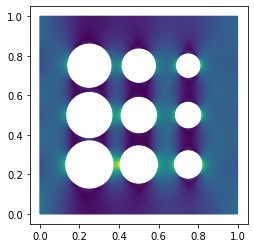

In [9]:
def mis_eps(ep):
    eps_dev = ep - Identity(2)*tr(ep)
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sigma(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis
S = FunctionSpace(mesh, 'P', 1)
sigma_Mis = project(mis_sigma(sig),S)
plot(sigma_Mis, mode='color')

In [10]:
# Save solution to file in VTK format
# eps_u = epsilon(u)
# sigma_u = sigma_el(u)
# eps_u = project(ep,T)
# sigma_u = project(sig,T)

u.rename('f_u','displacement')
sigma_Mis.rename('f_sigma_Mis','stress_Mis')
# eps_Mis.rename('f_eps_Mis','strain_Mis')
# sigma_u.rename('f_sigma_u','stress')
# eps_u.rename('f_eps_u','strain')

File('test_sample_deform/displacement_cp.pvd') << u
File('test_sample_deform/stress_Mis_cp.pvd') << sigma_Mis
# File('test_sample_deform/strain_Mis.pvd') << eps_Mis
# File('test_sample_deform/strain.pvd') << eps_u
# File('test_sample_deform/stess.pvd') << sigma_u